In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Charger le fichier CSV
df = pd.read_csv("/home/onyxia/work/Statapp_Valuco/ValueCo data extract - ENSAE research project.csv")

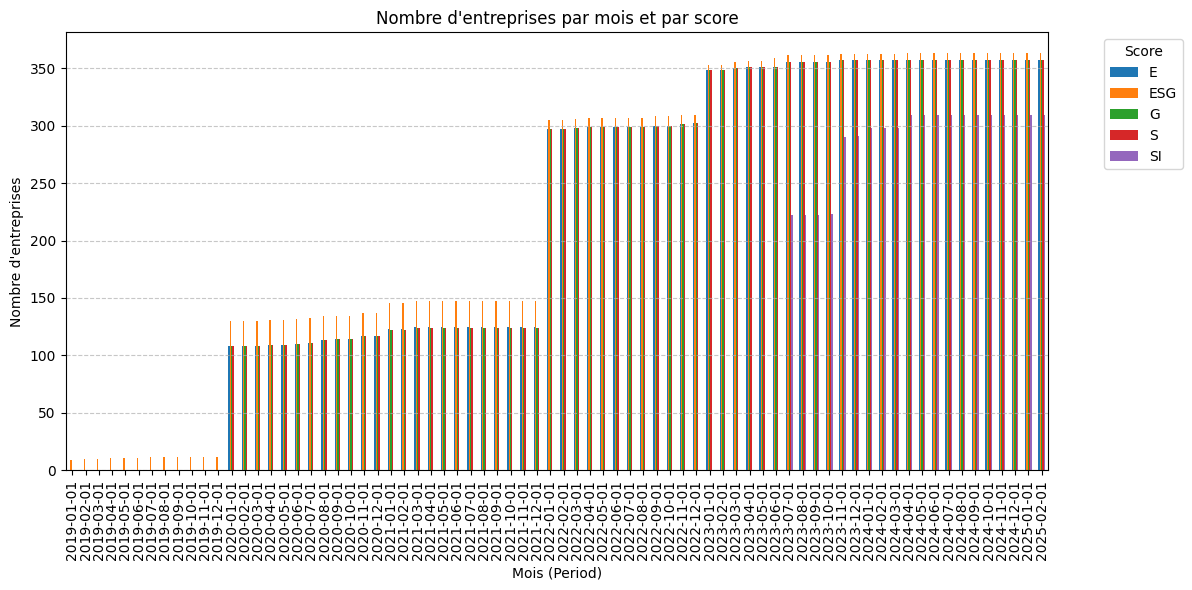

In [3]:
resultat = (
    df.groupby(['score_kind', 'period'])
    .agg(nombre_entreprises=('name', 'nunique'))
    .reset_index()
)

# 3. Pivoter pour avoir les scores en colonnes (si plusieurs scores)
resultat_pivot = resultat.pivot(
    index='period', 
    columns='score_kind', 
    values='nombre_entreprises'
)

# 4. Créer un diagramme en barres empilées (ou groupées)
resultat_pivot.plot(kind='bar', stacked=False, figsize=(12, 6))

# 5. Personnalisation du graphique
plt.title("Nombre d'entreprises par mois et par score")
plt.xlabel("Mois (Period)")
plt.ylabel("Nombre d'entreprises")
plt.legend(title='Score', bbox_to_anchor=(1.05, 1))  # Légende à droite
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Ajuster les marges

# 6. Afficher et sauvegarder

plt.show()

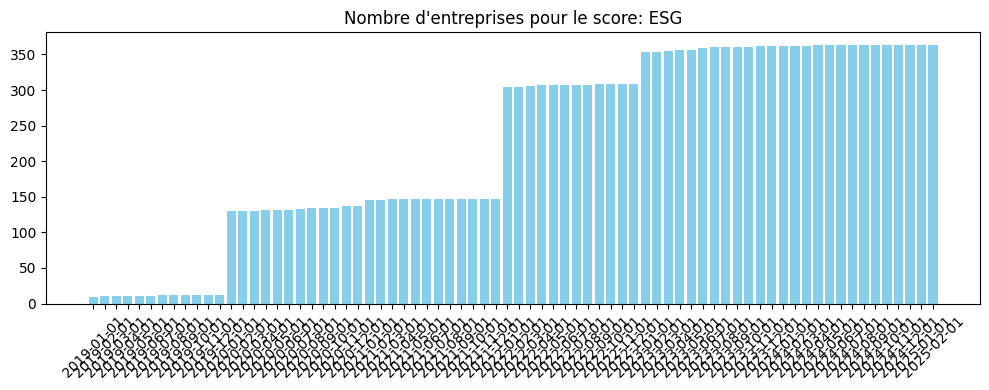

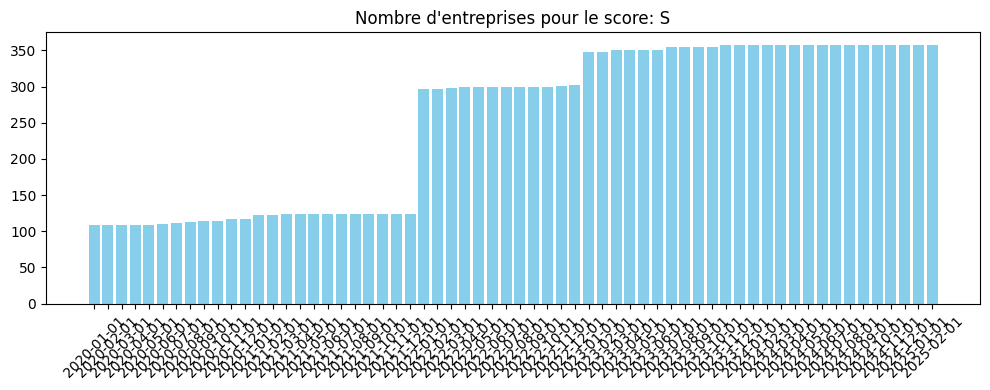

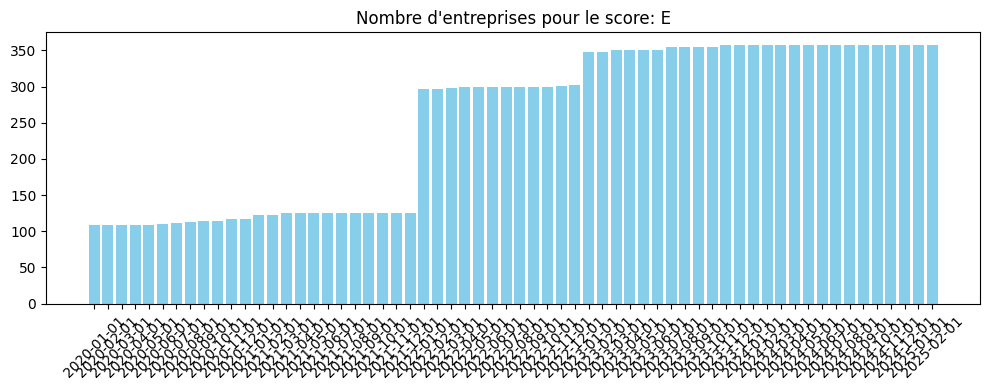

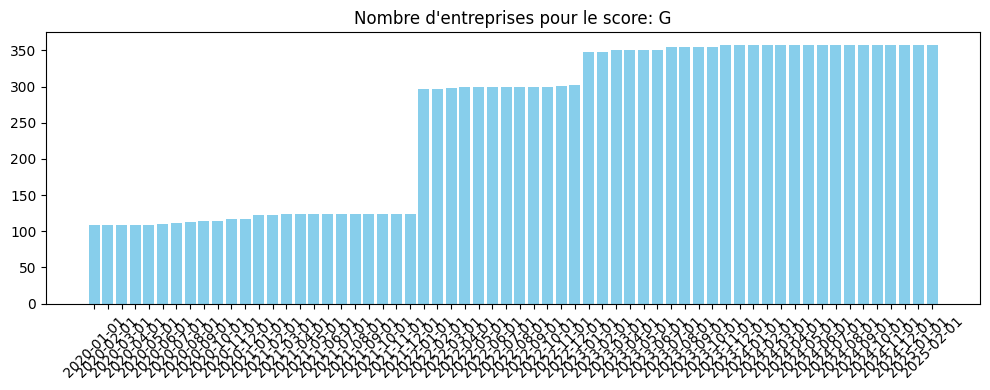

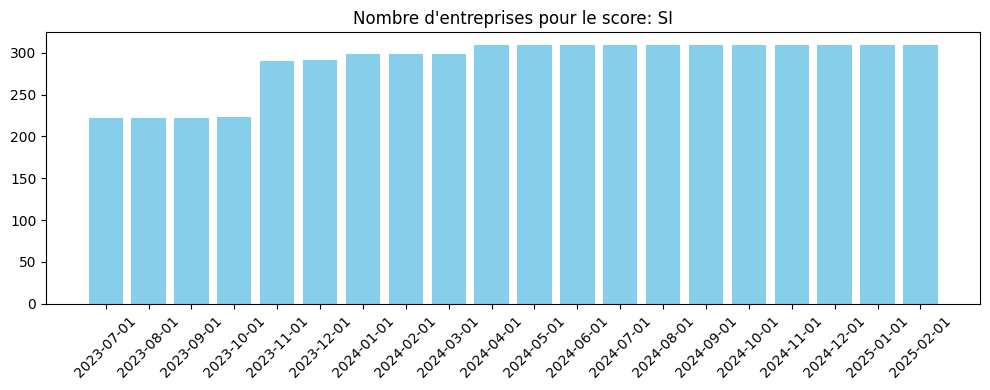

In [5]:
scores = df['score_kind'].unique()

# Boucle pour générer un graphique par score
for score in scores:
    df_score = df[df['score_kind'] == score]
    resultat = df_score.groupby('period').agg(nombre_entreprises=('name', 'nunique')).reset_index()
    
    plt.figure(figsize=(10, 4))
    plt.bar(resultat['period'], resultat['nombre_entreprises'], color='skyblue')
    plt.title(f"Nombre d'entreprises pour le score: {score}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [34]:
def calculer_persistance_entreprise(df, entreprise, score_cible):
    """ Vérifie si une entreprise a conservé le score cible chaque mois depuis sa première apparition """
    df_ent = df[df['name'] == entreprise].copy()
    df_ent['period'] = pd.to_datetime(df_ent['period'])
    df_ent['mois'] = df_ent['period'].dt.to_period('M')
    df_ent = df_ent.sort_values('period')

    # Mois où l'entreprise a eu le score cible
    mois_score = df_ent[df_ent['score_kind'] == score_cible]['mois'].unique()
    if len(mois_score) == 0:
        return False

    premiere_mois = mois_score.min()
    derniere_mois = df_ent['mois'].max()

    # Mois attendus : tous les mois calendaires à partir de la première apparition du score
    mois_attendus = pd.period_range(start=premiere_mois, end=derniere_mois, freq='M')

    for mois in mois_attendus:
        df_mois = df_ent[df_ent['mois'] == mois]
        # Si l'entreprise n'est pas présente ce mois → pas persistante
        if df_mois.empty:
            return False

        # Si l'entreprise est là mais n'a pas le score cible → pas persistante
        if score_cible not in df_mois['score_kind'].values:
            return False

    return True

def generer_tableau_persistance(df):
    """ Génère un tableau Score / % d'entreprises persistantes selon la logique mensuelle """
    scores = df['score_kind'].unique()
    resultats = {}

    for score in scores:
        # On récupère les entreprises qui ont eu AU MOINS UNE FOIS ce score
        entreprises = df[df['score_kind'] == score]['name'].unique()
        if len(entreprises) == 0:
            resultats[score] = 0.0
            continue

        # On compte combien d'entreprises sont persistantes pour ce score
        persistantes = sum(
            calculer_persistance_entreprise(df, entreprise, score)
            for entreprise in entreprises
        )

        resultats[score] = round((persistantes / len(entreprises)) * 100, 2)

    # Création du DataFrame de résultats trié
    tableau = pd.DataFrame({
        'Score': resultats.keys(),
        '% Persistance': resultats.values()
    }).sort_values('% Persistance', ascending=False)

    return tableau

generer_tableau_persistance(df)

def export_tableau_matplotlib(df_resultat, nom_fichier='tableau_persistance.png'):
    """ Version utilisant matplotlib """
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.axis('off')
    
    # Création du tableau
    table = plt.table(cellText=df_resultat.values,
                     colLabels=df_resultat.columns,
                     loc='center',
                     cellLoc='center')
    
    # Style
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)
    
    # Couleurs alternées
    for k, cell in table._cells.items():
        if k[0] == 0:  # Header
            cell.set_facecolor('#40466e')
            cell.set_text_props(color='white')
        elif k[0] % 2 == 1:  # Lignes impaires
            cell.set_facecolor('#f1f1f1')
    
    plt.savefig(nom_fichier, bbox_inches='tight', dpi=120)
    plt.close()
    print(f"Tableau exporté sous {nom_fichier}")

# Utilisation
export_tableau_matplotlib(tableau_persistance)

Tableau exporté sous tableau_persistance.png


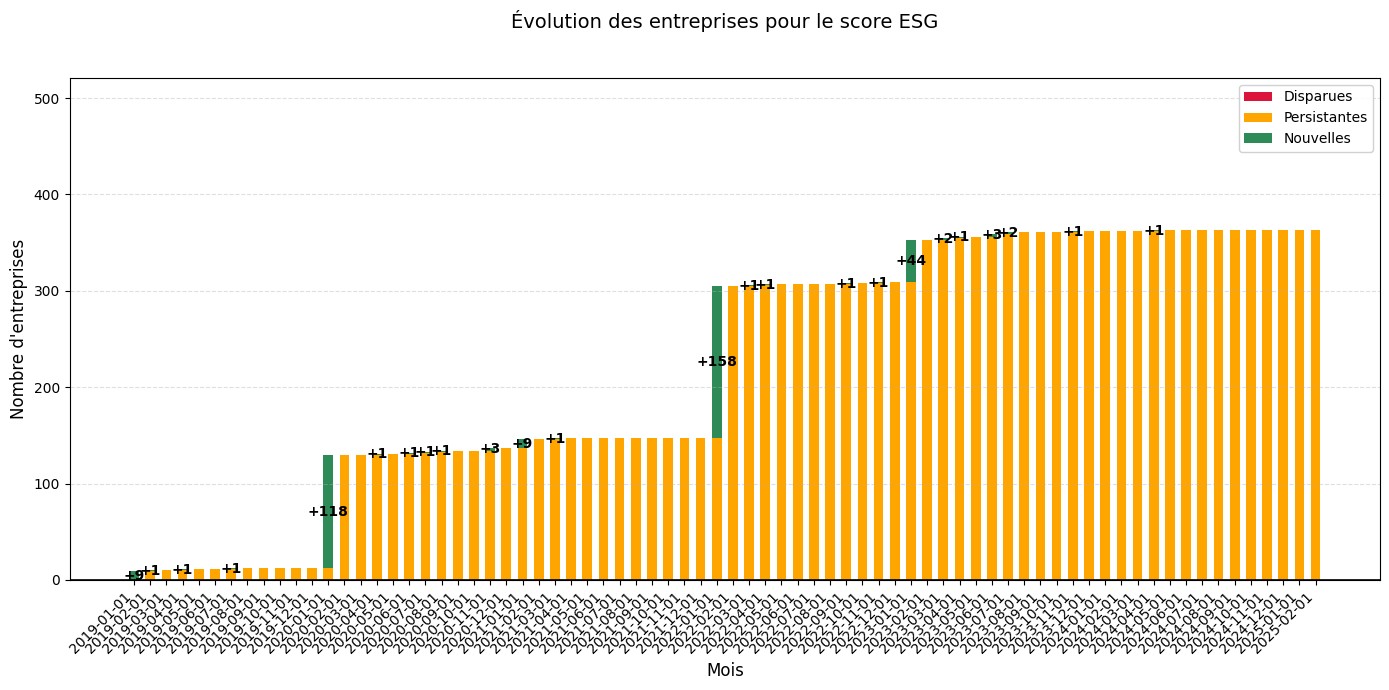

In [32]:


def histogramme_evolution_score(df, score_cible):
    """
    Crée un histogramme empilé verticalement avec:
    - Partie négative agrandie (disparitions)
    - Pas d'étiquette sur la partie persistante
    - Échelle adaptée pour mieux voir les variations
    """
    # Filtrer pour le score cible et trier par période
    df_score = df[df['score_kind'] == score_cible].sort_values('period')
    periods = sorted(df_score['period'].unique())
    
    if not periods:
        print(f"Aucune donnée pour le score {score_cible}")
        return
    
    # Dictionnaires pour stocker les résultats
    nouvelles = {}
    persistantes = {}
    disparues = {}
    
    # Premier mois (toutes nouvelles)
    prev_entreprises = set(df_score[df_score['period'] == periods[0]]['name'])
    nouvelles[periods[0]] = len(prev_entreprises)
    persistantes[periods[0]] = 0
    disparues[periods[0]] = 0
    
    # Analyse mois par mois
    for i in range(1, len(periods)):
        curr_period = periods[i]
        prev_period = periods[i-1]
        
        curr_entreprises = set(df_score[df_score['period'] == curr_period]['name'])
        
        nouvelles[curr_period] = len(curr_entreprises - prev_entreprises)
        persistantes[curr_period] = len(curr_entreprises & prev_entreprises)
        disparues[curr_period] = -len(prev_entreprises - curr_entreprises)  # Négatif
        
        prev_entreprises = curr_entreprises
    
    # Préparation des données
    periods_str = [str(p) for p in periods]
    width = 0.6
    
    # Création du graphique avec échelle adaptée
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # 1. Barres disparues (négatif) - en premier pour l'échelle
    bar_disparues = ax.bar(periods_str, disparues.values(), 
                          width, color='#DC143C', label='Disparues')
    
    # 2. Barres persistantes (base)
    bar_persist = ax.bar(periods_str, persistantes.values(), 
                        width, color='#FFA500', label='Persistantes',
                        bottom=[0]*len(periods))  # Commence à y=0
    
    # 3. Barres nouvelles (positif)
    bar_nouvelles = ax.bar(periods_str, nouvelles.values(), 
                          width, color='#2E8B57', label='Nouvelles',
                          bottom=persistantes.values())
    
    # Personnalisation avancée
    ax.set_title(f'Évolution des entreprises pour le score {score_cible}\n', pad=20, fontsize=14)
    ax.set_xlabel('Mois', fontsize=12)
    ax.set_ylabel('Nombre d\'entreprises', fontsize=12)
    ax.axhline(0, color='black', linewidth=1.2)
    
    # Ajustement spécial de l'échelle y pour agrandir le négatif
    y_max = max(nouvelles.values()) + max(persistantes.values())
    y_min = min(disparues.values()) * 1.3  # 30% plus d'espace en négatif
    ax.set_ylim(y_min, y_max)
    
    # Légende améliorée
    ax.legend(loc='upper right', framealpha=0.9)
    
    # Affichage des valeurs uniquement sur nouvelles et disparues
    for i, (n, d) in enumerate(zip(nouvelles.values(), disparues.values())):
        if n > 0:
            ax.text(i, persistantes[periods[i]] + n/2, f'+{n}', 
                   ha='center', va='center', fontweight='bold')
        if d < 0:
            ax.text(i, d/2, f'{-d}', 
                   ha='center', va='center', fontweight='bold', color='white')
    
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation
histogramme_evolution_score(df, 'ESG')